In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yonaadehermawan","key":"376c7d0fa449c9d190796dbba24ba41b"}'}

In [3]:
!ls ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d aturner374/eighty-years-of-canadian-climate-data

  0% 0.00/991k [00:00<?, ?B/s]
100% 991k/991k [00:00<00:00, 66.5MB/s]


In [5]:
import zipfile
local_zip = '/content/eighty-years-of-canadian-climate-data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [13]:
data_train = pd.read_csv('Canadian_climate_history.csv')
data_train = data_train.dropna()
data_train.tail()

,LOCAL_DATE,MEAN_TEMPERATURE_CALGARY,TOTAL_PRECIPITATION_CALGARY,MEAN_TEMPERATURE_EDMONTON,TOTAL_PRECIPITATION_EDMONTON,MEAN_TEMPERATURE_HALIFAX,TOTAL_PRECIPITATION_HALIFAX,MEAN_TEMPERATURE_MONCTON,TOTAL_PRECIPITATION_MONCTON,MEAN_TEMPERATURE_MONTREAL,TOTAL_PRECIPITATION_MONTREAL,MEAN_TEMPERATURE_OTTAWA,TOTAL_PRECIPITATION_OTTAWA,MEAN_TEMPERATURE_QUEBEC,TOTAL_PRECIPITATION_QUEBEC,MEAN_TEMPERATURE_SASKATOON,TOTAL_PRECIPITATION_SASKATOON,MEAN_TEMPERATURE_STJOHNS,TOTAL_PRECIPITATION_STJOHNS,MEAN_TEMPERATURE_TORONTO,TOTAL_PRECIPITATION_TORONTO,MEAN_TEMPERATURE_VANCOUVER,TOTAL_PRECIPITATION_VANCOUVER,MEAN_TEMPERATURE_WHITEHORSE,TOTAL_PRECIPITATION_WHITEHORSE,MEAN_TEMPERATURE_WINNIPEG,TOTAL_PRECIPITATION_WINNIPEG
25499,24-Oct-2009 00:00:00,2.4,9.2,3.3,0.0,6.5,15.4,5.6,17.0,8.35,16.5,7.8,5.4,2.5,19.6,3.7,0.0,1.2,0.2,9.9,0.0,9.1,0.0,2.4,0.0,5.4,0.0
25500,25-Oct-2009 00:00:00,1.5,0.0,2.5,0.0,11.7,19.6,10.9,32.0,5.75,0.0,6.1,0.0,5.8,0.4,3.6,1.5,5.4,3.6,8.6,0.0,6.3,13.6,1.5,3.2,5.4,1.6
25501,26-Oct-2009 00:00:00,6.0,0.0,4.6,0.4,4.2,0.0,3.4,0.0,3.65,0.0,1.5,0.0,3.4,0.0,4.7,0.5,4.3,1.0,8.8,0.0,9.5,15.8,3.4,0.2,5.3,0.2
25502,27-Oct-2009 00:00:00,1.4,3.4,3.8,1.2,2.2,0.0,0.5,0.0,6.40,0.0,6.2,0.2,2.4,0.4,1.4,0.0,0.1,0.0,12.3,1.2,6.2,0.0,1.9,0.2,8.2,0.0
25504,29-Oct-2009 00:00:00,0.9,0.2,-2.5,1.6,3.1,0.0,1.9,0.0,5.85,0.0,6.2,0.2,3.3,0.0,-1.2,22.2,1.6,2.8,10.1,0.0,6.6,21.0,-2.0,0.0,3.5,8.2


In [14]:
data_train.isnull().sum()

LOCAL_DATE                        0
MEAN_TEMPERATURE_CALGARY          0
TOTAL_PRECIPITATION_CALGARY       0
MEAN_TEMPERATURE_EDMONTON         0
TOTAL_PRECIPITATION_EDMONTON      0
MEAN_TEMPERATURE_HALIFAX          0
TOTAL_PRECIPITATION_HALIFAX       0
MEAN_TEMPERATURE_MONCTON          0
TOTAL_PRECIPITATION_MONCTON       0
MEAN_TEMPERATURE_MONTREAL         0
TOTAL_PRECIPITATION_MONTREAL      0
MEAN_TEMPERATURE_OTTAWA           0
TOTAL_PRECIPITATION_OTTAWA        0
MEAN_TEMPERATURE_QUEBEC           0
TOTAL_PRECIPITATION_QUEBEC        0
MEAN_TEMPERATURE_SASKATOON        0
TOTAL_PRECIPITATION_SASKATOON     0
MEAN_TEMPERATURE_STJOHNS          0
TOTAL_PRECIPITATION_STJOHNS       0
MEAN_TEMPERATURE_TORONTO          0
TOTAL_PRECIPITATION_TORONTO       0
MEAN_TEMPERATURE_VANCOUVER        0
TOTAL_PRECIPITATION_VANCOUVER     0
MEAN_TEMPERATURE_WHITEHORSE       0
TOTAL_PRECIPITATION_WHITEHORSE    0
MEAN_TEMPERATURE_WINNIPEG         0
TOTAL_PRECIPITATION_WINNIPEG      0
dtype: int64

In [15]:
date = data_train['LOCAL_DATE'].values
temp = data_train['MEAN_TEMPERATURE_CALGARY'].values

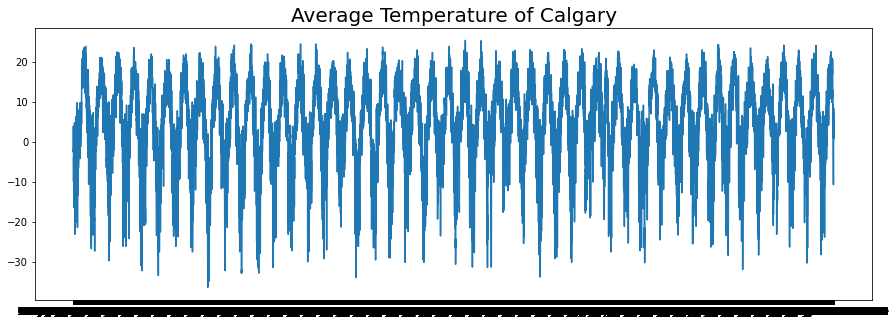

In [16]:
plt.figure(figsize=(15,5))
plt.plot(date, temp)
plt.title('Average Temperature of Calgary',
          fontsize=20);

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(temp, date, test_size = 0.2, shuffle=False)
print("X Train= ",len(X_train))
print("X Vaidation= ",len(X_validation))
print("Y train= ",len(y_train))
print("Y Validation= ",len(y_validation))

X Train=  13420
X Vaidation=  3356
Y train=  13420
Y Validation=  3356


In [49]:
Mae = (data_train['MEAN_TEMPERATURE_CALGARY'].max() - data_train['MEAN_TEMPERATURE_CALGARY'].min()) * 0.1
print("Avg Temp Max= ",data_train['MEAN_TEMPERATURE_CALGARY'].max())
print("Avg Temp Min= ",data_train['MEAN_TEMPERATURE_CALGARY'].min())
print("MAE= ",Mae)

Avg Temp Max=  25.4
Avg Temp Min=  -36.4
MAE=  6.18


In [50]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [51]:
train_set = windowed_dataset(X_train, window_size=60, batch_size=1024, shuffle_buffer=1000)
validation_set = windowed_dataset(X_validation, window_size=60, batch_size=1024, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"), 
  tf.keras.layers.Dense(1),
])

In [52]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< 6.18 and logs.get('val_mae')< 6.18):
      print("mae < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [53]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,metrics=["mae"])
trainmodel = model.fit(train_set,epochs=100,validation_data=validation_set,verbose=2,callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
14/14 - 33s - loss: 8.7311 - mae: 9.2202 - val_loss: 7.7429 - val_mae: 8.2310
Epoch 2/100
14/14 - 27s - loss: 7.1765 - mae: 7.6622 - val_loss: 6.0224 - val_mae: 6.5043
Epoch 3/100
14/14 - 27s - loss: 5.5307 - mae: 6.0122 - val_loss: 4.4776 - val_mae: 4.9550
mae < 10% skala data


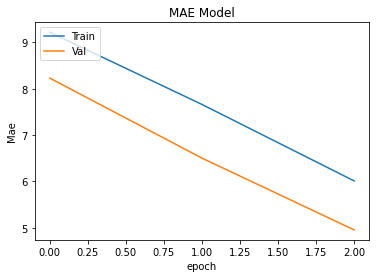

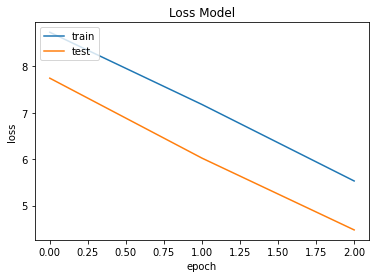

In [54]:
import matplotlib.pyplot as plt
# MAE
plt.plot(trainmodel.history['mae'])
plt.plot(trainmodel.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()  
#Loss
plt.plot(trainmodel.history['loss'])
plt.plot(trainmodel.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()